In [1]:
import numpy as np
import matplotlib.pyplot as plt
from extra_packages import OutputInterface as oi
from extra_packages import sperhical_expansion as se
import SFALinearPulse as sfa_lin
from matplotlib.colors import LogNorm
from itertools import repeat
import matplotlib as mpl

# Matplotlib asthetics
major = 7.5
minor = 5
width = 1.25
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc("axes", labelsize=16) # 18
plt.rc("xtick", labelsize=14, top=True, direction="in")
plt.rc("ytick", labelsize=14, right=True, direction="in")
plt.rc("axes", titlesize=18)
plt.rc("legend", fontsize=14)
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.linewidth'] = width
plt.rcParams['xtick.minor.width'] = width
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.minor.width'] = width
plt.rcParams['ytick.major.width'] = width
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor

In [2]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [3]:
import multiprocessing

try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 8   # arbitrary default

pool = multiprocessing.Pool(processes=cpus)

In [4]:
#output = oi.OutputInterface('output_files/R-H2O2_mod.out')
output = oi.OutputInterface('output_files/D-H2O2.out')
Ip = abs(output.saved_orbitals[output.HOMO][0])
kappa = np.sqrt(2*Ip)
omega = 0.057     # Frequency of light
Up = 0.22         # Ponderomotive potential
CEP = np.pi/2
N = 2

gto_coeffs = np.array(output.output_GTOs())

In [6]:
plot_list = np.linspace(0.1, 9, 75)
f_lms = se.laplace_several_r(output.eval_orbital_spherical, plot_list, 8, orbital_nr=output.HOMO)

r_list = np.linspace(3.0, 3.4, 50) ## 3.0, 3.4 ## # 4.5 5.0, 3.0 3.5, 3.5 4.0
clm_array = se.get_asymp_fit(output.eval_orbital_spherical, r_list, 8, Ip, orbital_nr=output.HOMO, ## 8 ##
                             threshold=1e-3, normalized=False)

# Get coefficients for other enantiomer via reflection in xy-plane: c_lm -> (-1)^(l+m)c_lm
clm_array2 = np.copy(clm_array)
for l in range(1, len(clm_array[0])):
    clm_array2[0, l, :] = clm_array[1, l, :]
    clm_array2[1, l, :] = clm_array[0, l, :]
#clm_array2[0, :, 1] = clm_array[1, :, 1]

for sgn in range(2):
    for l in range(clm_array.shape[1]):
        for m in range(0, l + 1):
            sign = 1.0 if sgn == 0 else -1.0
            clm_array2[sgn, l, m] *= (-1)**m

all_coeffs = np.array([np.array(gto_coeffs), np.array(clm_array)], dtype='object')

Evaluating at r=3.4000 	 Nr. 50/50
Now fitting!
Done!


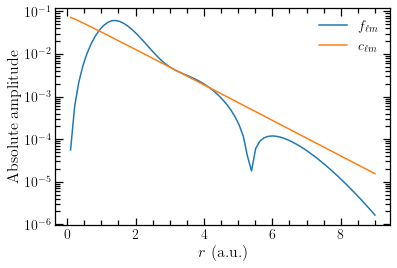

In [7]:
def asymp(r, clm):
    return clm * r**(1/kappa - 1) * np.exp(-kappa*r)

sgn, l, m = 0, 3, 1
plt.figure(facecolor='white')
plt.plot(plot_list, np.abs(f_lms[:, sgn, l, m]), label=r'$f_{\ell m}$')
plt.plot(plot_list, np.abs(asymp(plot_list, clm_array[sgn, l, m])), label=r'$c_{\ell m}$')
plt.xlabel('$r$ (a.u.)')
plt.ylabel('Absolute amplitude')
plt.legend(frameon=False)
plt.yscale('log')
plt.minorticks_on()
plt.show()

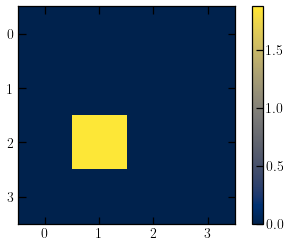

1.8734610473775828


In [8]:
plt.imshow(np.real(clm_array2[0])**2, cmap='cividis')
plt.colorbar()
plt.show()
print(np.abs(clm_array[0, 2, 1])**2)
#clm_array[1] = clm_array[0]
#clm_array[1][0] *= 0

In [9]:
# Print out the coefficients
clm_lst = se.convert_clm_array_to_list(clm_array)
print(np.sqrt(len(clm_lst)) - 1)
#np.savetxt('clm_coeffs_re.txt', np.real(clm_lst))
#np.savetxt('clm_coeffs_im.txt', np.imag(clm_lst))
coeffs = []
for re, im in zip(np.real(clm_lst), np.imag(clm_lst)):
    coeffs.append([re, im])
coeffs = np.array(coeffs)
np.savetxt('H2O2_coeffs.txt', coeffs)

3.0


## Let us plot the HOMO and the asymptotic expansion, to see if the look alike

In [49]:
from mayavi import mlab
l = 5
n = 100
iso = 0.01
x, y, z = np.mgrid[-l:l:n*1j, -l:l:n*1j, -l:l:n*1j]
mlab.figure(1, fgcolor=(1, 1, 1), bgcolor=(1, 1, 1))
orbital = output.eval_orbital(x, y, z)

mlab.contour3d(orbital, contours=[iso], transparent=False, color=(1, 0, 0))
mlab.contour3d(orbital, contours=[-iso], transparent=False, color=(0, 0, 1))
mlab.show()

In [60]:
asymp = np.real(se.eval_asymptotic_cart(x, y, z, clm_array2, Ip))
iso = 0.01
mlab.figure(1, fgcolor=(1, 1, 1), bgcolor=(1, 1, 1))
mlab.contour3d(asymp, contours=[iso], transparent=False, color=(1, 0, 0))
mlab.contour3d(asymp, contours=[-iso], transparent=False, color=(0, 0, 1))
mlab.show()


## PMD time

In [10]:
dp = 4. / 450
px_lst = np.arange(-1, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

sfa = sfa_lin.SFALinearPulse(Ip, Up, omega, N, CEP, 'asymp_martiny')
M_grd = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array))))
M_grd2 = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array2))))
M_sqr = np.abs(np.flip(M_grd, 0))**2
M_sqr2 = np.abs(np.flip(M_grd2, 0))**2
print('Done!')

Done!


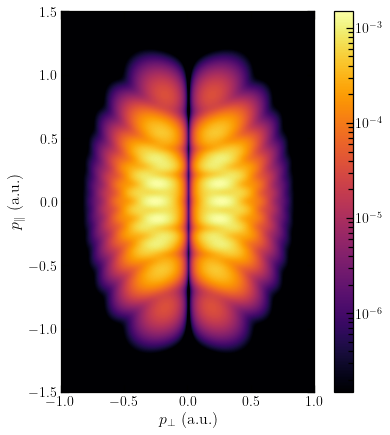

In [13]:
PMD = M_sqr2
plt.figure(facecolor='white', figsize=(7, 7))
plt.imshow(PMD, interpolation='bicubic', cmap='inferno',
                 norm=LogNorm(vmax=np.max(PMD), vmin=np.max(PMD)*1e-4),
                 extent=(-1, 1, -1.5, 1.5))
plt.xlabel(r'$p_\perp$ (a.u.)')
plt.ylabel(r'$p_\parallel$ (a.u.)')
plt.colorbar()
plt.show()

In [14]:
OAM_grd1 = []
OAM_grd2 = []
OAM_lst = [-2, -1, 1, 2]

dp = 4. / 175#450
px_lst = np.arange(0.01, 1, dp)
pz_lst = np.arange(-1.5, 1.5, dp)
py = 0.
px_grd, pz_grd = np.meshgrid(px_lst, pz_lst)

for OAM in OAM_lst:
    print(f'Doing OAM={OAM}')
    sfa.OAM = OAM
    M_l = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array))))
    OAM_grd1.append(M_l)
    M_l = np.array(pool.starmap(sfa.Mxz_List, zip(px_grd, repeat(py), pz_grd, repeat(clm_array2))))
    OAM_grd2.append(M_l)
OAM_grd_tot = [OAM_grd1, OAM_grd2]

Doing OAM=-2
Doing OAM=-1
Doing OAM=1
Doing OAM=2


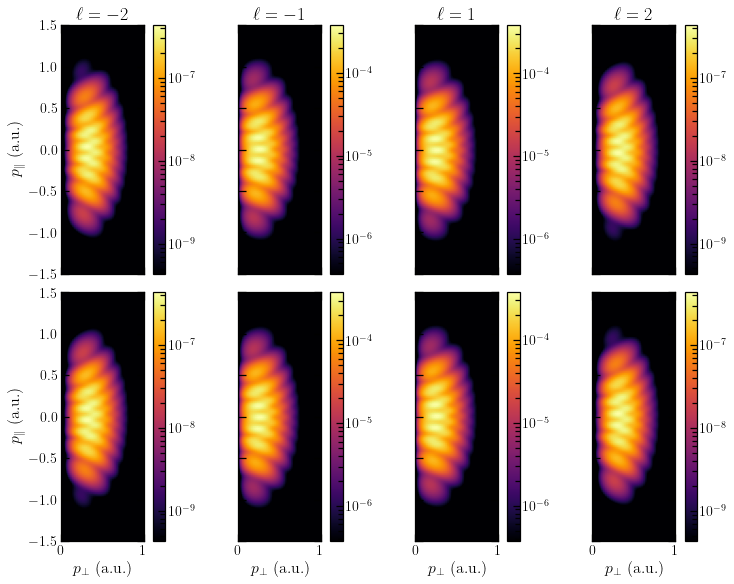

In [15]:
fig, axs = plt.subplots(2, len(OAM_lst), facecolor='white', figsize=(10, 8), constrained_layout=True, sharey='all', sharex='all')
for i in range(2):
    for j in range(len(OAM_lst)):
        im = axs[i, j].imshow(np.abs(OAM_grd_tot[i][j])**2, cmap='inferno',
                              norm=LogNorm(vmax=np.max(np.abs(OAM_grd_tot[i][j])**2), vmin=np.max(np.abs(OAM_grd_tot[i][j])**2)*1e-3),
                              extent=(0, 1, -1.5, 1.5))
        plt.colorbar(im, ax=axs[i, j], shrink=1)
        if i == 0:
            axs[i, j].set_title(f'$\ell={OAM_lst[j]}$')
        if i == 1:
            axs[i, j].set_xlabel(r'$p_\perp$ (a.u.)')
        if j == 0:
            axs[i, j].set_ylabel(r'$p_\parallel$ (a.u.)')
#plt.show()

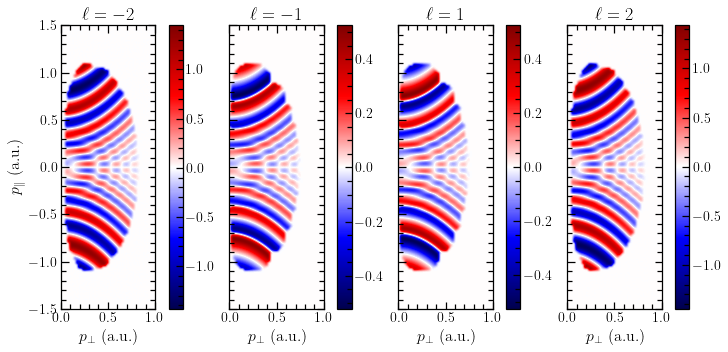

In [21]:
num = len(OAM_lst)
threshold = 0.125e-2
fig, axs = plt.subplots(1, num, facecolor='white', figsize=(10, 8), constrained_layout=True, sharey='all', sharex='all')
count = 0
for ax, Ml1, Ml2, l in zip(axs, OAM_grd_tot[0], OAM_grd_tot[1], OAM_lst):
    Ml1 = np.abs(Ml1)**2
    Ml2 = np.abs(Ml2)**2
    #Ml2 = np.flip(Ml2, 0)
    PEVD = 2*((Ml1 - Ml2)/(Ml1 + Ml2))
    PEVD = np.nan_to_num(PEVD, nan=0)
    filter_list1 = Ml1 > np.max(Ml1 * threshold)
    filter_list2 = Ml2 > np.max(Ml2 * threshold)
    combined_filter = np.logical_or(filter_list1, filter_list2)
    PEVD[np.logical_not(combined_filter)] = 0
    im = ax.imshow(PEVD, cmap='seismic', norm=MidpointNormalize(np.min(PEVD), np.max(PEVD)),
                   extent=(0, 1, -1.5, 1.5), interpolation='bicubic')
    cbar = plt.colorbar(im, ax=ax)
    cbar.minorticks_on()
    ax.set_xlabel(r'$p_\perp$ (a.u.)')
    ax.minorticks_on()
    if count == 0:
        ax.set_ylabel(r'$p_\parallel$ (a.u.)')
    ax.set_title(f'$\ell={OAM_lst[count]}$')
    count += 1
plt.show()

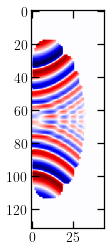

0.5332996294708229


In [41]:
plt.figure(facecolor='white')
Ml1 = np.abs(OAM_grd_tot[0][1])**2
Ml2 = np.abs(OAM_grd_tot[0][2])**2
#Ml2 = np.flip(Ml2, 0)
PEVD = 2*((Ml1 - Ml2)/(Ml1 + Ml2))
PEVD = np.nan_to_num(PEVD, nan=0)
filter_list1 = Ml1 > np.max(Ml1 * threshold)
filter_list2 = Ml2 > np.max(Ml2 * threshold)
combined_filter = np.logical_or(filter_list1, filter_list2)
PEVD[np.logical_not(combined_filter)] = 0
plt.imshow(PEVD, cmap='seismic')#, norm=MidpointNormalize(-2, 2), extent=(-1, 1, -1.5, 1.5))
plt.show()
print(np.max(PEVD))